<a href="https://colab.research.google.com/github/Sai0472003/PatentLitigation_Impact/blob/main/Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Data Loading and Cleaning

In [39]:
plt_rnd = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_plt_rnd.csv')
plt_rnd = plt_rnd.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
plt_rnd = plt_rnd.dropna(subset=['filing_rd_sale','closing_rd_sale'])

plt_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_plt_npm.csv')
plt_npm = plt_npm.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
plt_npm = plt_npm.rename(columns={'npm_filing_quarter': 'filing_npm', 'npm_closing_quarter': 'closing_npm'})
rename_dict = {
    # Filing columns
    'npm_filed_minus_1': 'filed_minus_1_npm',
    'npm_filed_minus_2': 'filed_minus_2_npm',
    'npm_filed_minus_3': 'filed_minus_3_npm',
    'npm_filed_minus_4': 'filed_minus_4_npm',
    'npm_filed_minus_5': 'filed_minus_5_npm',
    'npm_filed_minus_6': 'filed_minus_6_npm',
    'npm_filed_minus_7': 'filed_minus_7_npm',
    'npm_filed_minus_8': 'filed_minus_8_npm',
    'npm_filed_minus_9': 'filed_minus_9_npm',
    'npm_filed_minus_10': 'filed_minus_10_npm',

    # Closing columns
    'npm_closed_plus_1': 'closed_plus_1_npm',
    'npm_closed_plus_2': 'closed_plus_2_npm',
    'npm_closed_plus_3': 'closed_plus_3_npm',
    'npm_closed_plus_4': 'closed_plus_4_npm',
    'npm_closed_plus_5': 'closed_plus_5_npm',
    'npm_closed_plus_6': 'closed_plus_6_npm',
    'npm_closed_plus_7': 'closed_plus_7_npm',
    'npm_closed_plus_8': 'closed_plus_8_npm',
    'npm_closed_plus_9': 'closed_plus_9_npm',
    'npm_closed_plus_10': 'closed_plus_10_npm'
}
plt_npm = plt_npm.rename(columns=rename_dict)
plt_npm = plt_npm.dropna(subset=['filing_npm', 'closing_npm'])

def_rnd = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_def_rnd.csv')
def_rnd = def_rnd.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
def_rnd = def_rnd.dropna(subset=['filing_rd_sale','closing_rd_sale'])

def_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_def_npm.csv')
def_npm = def_npm.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
def_npm = def_npm.dropna(subset=['filing_npm', 'closing_npm'])

In [40]:
#loading pre-cleaned csv files
clean_plaintiff_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_RnD.csv')
clean_plaintiff_RnD = clean_plaintiff_RnD[['case_number', 'filing_quarter_rnd',
                                           'closing_quarter_rnd', 'delta_rnd_sales',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_plaintiff_RnD = clean_plaintiff_RnD.merge(plt_rnd, on='case_number', how='left')
clean_plaintiff_RnD = clean_plaintiff_RnD.drop_duplicates()


clean_defendent_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_RnD.csv')
clean_defendent_RnD = clean_defendent_RnD[['case_number', 'filing_quarter_rnd',
                                           'closing_quarter_rnd', 'delta_rnd_sales',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_defendent_RnD = clean_defendent_RnD.merge(def_rnd, on='case_number', how='left')
clean_defendent_RnD = clean_defendent_RnD.drop_duplicates()


clean_plaintiff_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_npm.csv')
clean_plaintiff_npm = clean_plaintiff_npm[['case_number', 'filing_quarter_npm',
                                           'closing_quarter_npm', 'delta_npm',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_plaintiff_npm = clean_plaintiff_npm.merge(plt_npm, on='case_number', how='left')
clean_plaintiff_npm = clean_plaintiff_npm.drop_duplicates()

clean_defendent_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_npm.csv')
clean_defendent_npm = clean_defendent_npm[['case_number', 'filing_quarter_npm',
                                           'closing_quarter_npm', 'delta_npm',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_defendent_npm = clean_defendent_npm.merge(def_npm, on='case_number',how='left')
clean_defendent_npm = clean_defendent_npm.drop_duplicates()

pd.set_option('display.max_columns', None)

In [41]:
#adding defendant/plaintiff dummies and cocat merging into single df
clean_plaintiff_npm['plaintiff'] = 1
clean_defendent_npm['defendant'] = 1

npm = pd.concat([clean_defendent_npm, clean_plaintiff_npm], axis=0)
npm['defendant'] = npm['defendant'].fillna(0)
npm['plaintiff'] = npm['plaintiff'].fillna(0)

#converting case length variable from days to number of fin. quarters
npm['date_filed'] = pd.to_datetime(npm['date_filed'])
npm['date_closed'] = pd.to_datetime(npm['date_closed'])
npm['quarter_filed'] = npm['date_filed'].dt.to_period('Q')
npm['quarter_closed'] = npm['date_closed'].dt.to_period('Q')
npm['case_length'] = (npm['quarter_closed'] - npm['quarter_filed']).apply(lambda x: x.n) + 1

#dummy identifying if a given row corresponds to defendent or plaintiff firm
clean_plaintiff_RnD['plaintiff'] = 1
clean_defendent_RnD['defendant'] = 1

rnd = pd.concat([clean_defendent_RnD, clean_plaintiff_RnD], axis=0)
rnd['defendant'] = rnd['defendant'].fillna(0)
rnd['plaintiff'] = rnd['plaintiff'].fillna(0)


#converting case length variable from days to number of fin. quarters
rnd['date_filed'] = pd.to_datetime(rnd['date_filed'])
rnd['date_closed'] = pd.to_datetime(rnd['date_closed'])
rnd['quarter_filed'] = rnd['date_filed'].dt.to_period('Q')
rnd['quarter_closed'] = rnd['date_closed'].dt.to_period('Q')
rnd['case_length'] = (rnd['quarter_closed'] - rnd['quarter_filed']).apply(lambda x: x.n) + 1

In [42]:
JFC_data = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/without_dummies_cases.csv')

JFC_data = JFC_data[['case_number', 'case_name','PLT', 'DEF', 'jurisdictional_basis',
                     'CIRCUIT', 'DISTRICT', 'OFFICE', 'JURY', 'NOS', 'CLASSACT',
                     'COUNTY', 'PROCPROG', 'DISP', 'NOJ', 'JUDGMENT']]

In [43]:
rnd.columns

Index(['case_number', 'filing_quarter_rnd', 'closing_quarter_rnd',
       'delta_rnd_sales', 'state_province', 'case_length', 'materials',
       'industrials', 'consumer_discretionary', 'info_tech', 'health_care',
       'case_row_id', 'date_filed', 'date_closed', 'DEF', 'gvkey',
       'filing_rd_sale', 'closing_rd_sale', 'filed_minus_1_rd_sale',
       'filed_minus_2_rd_sale', 'filed_minus_3_rd_sale',
       'filed_minus_4_rd_sale', 'filed_minus_5_rd_sale',
       'filed_minus_6_rd_sale', 'filed_minus_7_rd_sale',
       'filed_minus_8_rd_sale', 'filed_minus_9_rd_sale',
       'filed_minus_10_rd_sale', 'closed_plus_1_rd_sale',
       'closed_plus_2_rd_sale', 'closed_plus_3_rd_sale',
       'closed_plus_4_rd_sale', 'closed_plus_5_rd_sale',
       'closed_plus_6_rd_sale', 'closed_plus_7_rd_sale',
       'closed_plus_8_rd_sale', 'closed_plus_9_rd_sale',
       'closed_plus_10_rd_sale', 'defendant', 'PLT', 'plaintiff',
       'quarter_filed', 'quarter_closed'],
      dtype='object')

In [44]:
#merging in JFC data and logging all rnd and npm columns
npm = npm.merge(JFC_data, on='case_number', how='left')
npm = npm[(npm['delta_npm'] > -3) & (npm['delta_npm'] < 3)]


rnd = rnd.merge(JFC_data, on='case_number', how='left')
rnd = rnd[(rnd['delta_rnd_sales'] > -3) & (rnd['delta_rnd_sales'] < 3)]

In [45]:
npm.head()

,case_number,filing_quarter_npm,closing_quarter_npm,delta_npm,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_npm,closing_npm,filed_minus_1_npm,filed_minus_2_npm,filed_minus_3_npm,filed_minus_4_npm,filed_minus_5_npm,filed_minus_6_npm,filed_minus_7_npm,filed_minus_8_npm,filed_minus_9_npm,filed_minus_10_npm,closed_plus_1_npm,closed_plus_2_npm,closed_plus_3_npm,closed_plus_4_npm,closed_plus_5_npm,closed_plus_6_npm,closed_plus_7_npm,closed_plus_8_npm,closed_plus_9_npm,closed_plus_10_npm,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,jurisdictional_basis,CIRCUIT,DISTRICT,OFFICE,JURY,NOS,CLASSACT,COUNTY,PROCPROG,DISP,NOJ,JUDGMENT
0,2:11-cv-01037,0.163247,0.226309,0.063062,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.163247,0.226309,0.208424,0.222403,0.228644,0.231133,0.218727,0.208168,0.182834,0.140980,0.093009,0.090787,0.226309,0.228330,0.227446,0.229692,0.236506,0.245290,0.257436,0.268886,0.281967,0.290327,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,Federal Question,11,27,2,B,830,0,1123,10,14,0,0
1,1:15-cv-01059,0.244910,0.796015,0.551105,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.244910,0.796015,-0.038337,0.002570,0.177977,0.177977,0.177977,0.177977,0.177692,0.177340,0.186757,0.185404,0.796015,0.783359,-0.105780,-0.160819,-0.098993,-0.078669,0.235250,0.249267,0.235700,0.195106,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,Federal Question,11,26,1,B,830,0,1029,10,13,0,0
2,5:11-cv-01349,0.051063,0.047465,-0.003598,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.051063,0.047465,0.051389,0.052812,0.056058,0.059108,0.050739,0.038591,0.021813,0.017965,0.022998,0.030151,0.047465,0.066061,0.066351,0.069411,0.071422,0.050828,0.055643,0.055991,0.050594,0.058694,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",Federal Question,11,26,5,P,830,0,1043,10,13,0,0
3,2:87-cv-00979,0.010817,0.037153,0.026336,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.010817,0.037153,0.011557,0.016528,0.014094,0.007289,0.002005,-0.004607,-0.007360,-0.008743,-0.013173,-0.015351,0.037153,0.034018,0.029158,0.023642,0.022023,0.024052,0.023840,0.024025,0.021345,0.019084,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,Federal Question,11,26,2,-8,830,0,88888,5,13,-8,-8
4,1:17-cv-00179,0.208723,0.210924,0.002201,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.208723,0.210924,0.207433,0.207305,0.212408,0.217516,0.223264,0.229189,0.228458,0.226164,0.225335,0.222533,0.210924,0.211246,0.215499,0.220046,0.224341,0.227377,0.221371,0.215010,0.212381,0.214907,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,Federal Question,11,28,1,B,830,0,1097,3,12,0,0


In [46]:
rnd.head()

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,jurisdictional_basis,CIRCUIT,DISTRICT,OFFICE,JURY,NOS,CLASSACT,COUNTY,PROCPROG,DISP,NOJ,JUDGMENT
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,Federal Question,11,27,2,B,830,0,1123,10,14,0,0
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,Federal Question,11,26,1,B,830,0,1029,10,13,0,0
2,5:11-cv-01349,0.000000,0.000000,0.000000,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",Federal Question,11,26,5,P,830,0,1043,10,13,0,0
3,2:87-cv-00979,0.000000,0.000000,0.000000,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,Federal Question,11,26,2,-8,830,0,88888,5,13,-8,-8
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,Federal Question,11,28,1,B,830,0,1097,3,12,0,0


# Creating Useful Dummies for the JFC Categorical Data

In [47]:
#using PROCPROG to create disp_before_issue_joined
npm['disp_before_issue_joined'] = 0
rnd['disp_before_issue_joined'] = 0

npm.loc[npm['PROCPROG'].isin([1,2,11,12]), 'disp_before_issue_joined'] = 1
rnd.loc[rnd['PROCPROG'].isin([1,2,11,12]), 'disp_before_issue_joined'] = 1

npm = npm.drop(columns=['PROCPROG'])
rnd = rnd.drop(columns=['PROCPROG'])

In [48]:
#using DISP to create dummies for dissmissals, final judgment and case transfers

#For the npm df
npm['disp_dismissed'] = 0
npm['disp_judgment'] = 0
npm['disp_transfer'] = 0

npm.loc[npm['DISP'].isin([0,1,10,11]), 'disp_transfer'] = 1
npm.loc[npm['DISP'].isin([2,3,12,13,14]), 'disp_dismissed'] = 1
npm.loc[npm['DISP'].isin([4,5,6,7,8,9,15,16,17,18,19,20]), 'disp_judgment'] = 1

#extra dummies for dismissals with settlement or voluntary withdrawl by plaintiff
npm['dismissed_settlement'] = 0
npm['dismissed_voluntary'] = 0

npm.loc[npm['DISP'].isin([13]), 'dismissed_settlement'] = 1
npm.loc[npm['DISP'].isin([12]), 'dismissed_voluntary'] = 1


npm = npm.drop(columns=['DISP'])

#For the rnd df
rnd['disp_dismissed'] = 0
rnd['disp_judgment'] = 0
rnd['disp_transfer'] = 0

rnd.loc[rnd['DISP'].isin([0,1,10,11]), 'disp_transfer'] = 1
rnd.loc[rnd['DISP'].isin([2,3,12,13,14]), 'disp_dismissed'] = 1
rnd.loc[rnd['DISP'].isin([4,5,6,7,8,9,15,16,17,18,19,20]), 'disp_judgment'] = 1

#extra dummies for dismissals with settlement or voluntary withdrawl by plaintiff
rnd['dismissed_settlement'] = 0
rnd['dismissed_voluntary'] = 0

rnd.loc[rnd['DISP'].isin([13]), 'dismissed_settlement'] = 1
rnd.loc[rnd['DISP'].isin([12]), 'dismissed_voluntary'] = 1

rnd = rnd.drop(columns=['DISP'])

In [49]:
#using JUDGMENT to create dummies for who one the cases that went to judgment

#for the npm df
npm['judgment_favor_plt'] = 0
npm['judgment_favor_def'] = 0
npm['judgment_favor_both'] = 0

npm.loc[npm['JUDGMENT'].isin([1]), 'judgment_favor_plt'] = 1
npm.loc[npm['JUDGMENT'].isin([2]), 'judgment_favor_def'] = 1
npm.loc[npm['JUDGMENT'].isin([3]), 'judgment_favor_both'] = 1

npm = npm.drop(columns=['JUDGMENT'])

#for the rnd df
rnd['judgment_favor_plt'] = 0
rnd['judgment_favor_def'] = 0
rnd['judgment_favor_both'] = 0

rnd.loc[rnd['JUDGMENT'].isin([1]), 'judgment_favor_plt'] = 1
rnd.loc[rnd['JUDGMENT'].isin([2]), 'judgment_favor_def'] = 1
rnd.loc[rnd['JUDGMENT'].isin([3]), 'judgment_favor_both'] = 1

rnd = rnd.drop(columns=['JUDGMENT'])

In [50]:
#using NOJ to extract more info about judgment for cases that have judgments

#for the npm df
npm['judgment_monetary_award'] = 0
npm['judgment_injunction'] = 0
npm['judgment_ordered_loss'] = 0

npm.loc[npm['NOJ'].isin([1,2]), 'judgment_monetary_award'] = 1
npm.loc[npm['NOJ'].isin([2]), 'judgment_injunction'] = 1
npm.loc[npm['NOJ'].isin([3,4,5]), 'judgment_monetary_award'] = 1

npm = npm.drop(columns=['NOJ'])

#for the rnd df
rnd['judgment_monetary_award'] = 0
rnd['judgment_injunction'] = 0
rnd['judgment_ordered_loss'] = 0

rnd.loc[rnd['NOJ'].isin([1,2]), 'judgment_monetary_award'] = 1
rnd.loc[rnd['NOJ'].isin([2]), 'judgment_injunction'] = 1
rnd.loc[rnd['NOJ'].isin([3,4,5]), 'judgment_monetary_award'] = 1

rnd = rnd.drop(columns=['NOJ'])

In [51]:
#using jurisdictional basis to create dummies for Fed_Question, US_def and US_plt
npm['FED_QUESTION'] = 0
npm['US_DEF'] = 0
npm['US_PLT'] = 0

npm.loc[npm['jurisdictional_basis'].isin(['Federal Question']), 'FED_QUESTION'] = 1

In [52]:
#filtering out trivial number of 840 trademark infringement cases, focusing on 830 patent infringement
rnd = rnd[rnd['NOS'] == 830]
npm = npm[npm['NOS'] == 830]

#filtering out trivial number of US defendent/plaintiff cases, focusing on Federal Questions
rnd = rnd[rnd['jurisdictional_basis'].isin(['Federal Question'])]
npm = npm[npm['jurisdictional_basis'].isin(['Federal Question'])]

npm = npm.drop(columns=['jurisdictional_basis'])
rnd = rnd.drop(columns=['jurisdictional_basis'])

#droping CLASSACT because no classaction suites exist in data
npm = npm.drop(columns=['CLASSACT'])
rnd = rnd.drop(columns=['CLASSACT'])

#dropping NOS because all cases are 830 infringement
npm = npm.drop(columns=['NOS'])
rnd = rnd.drop(columns=['NOS'])

#ensuring the column for Office includes the district under which the case is filed
npm['OFFICE'] = npm['DISTRICT'].astype(str) + '.' + npm['OFFICE'].astype(str)
rnd['OFFICE'] = rnd['DISTRICT'].astype(str) + '.' + rnd['OFFICE'].astype(str)

#creating measure of past performance
npm['past_performance'] = (npm['filed_minus_4_npm'] + npm['filed_minus_3_npm'] + npm['filed_minus_2_npm'] + npm['filed_minus_1_npm'])/4
rnd['past_performance'] = (rnd['filed_minus_4_rd_sale'] + rnd['filed_minus_3_rd_sale'] + rnd['filed_minus_2_rd_sale'] + rnd['filed_minus_1_rd_sale'])/4

In [53]:
rnd.head()

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,past_performance
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0,0.115615
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0,0.055669
2,5:11-cv-01349,0.000000,0.000000,0.000000,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,0.000000
3,2:87-cv-00979,0.000000,0.000000,0.000000,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,11,26,26.2,-8,88888,0,1,0,0,1,0,0,0,0,0,0,0,0.000000
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0,0.046975


In [54]:
npm.head()

,case_number,filing_quarter_npm,closing_quarter_npm,delta_npm,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_npm,closing_npm,filed_minus_1_npm,filed_minus_2_npm,filed_minus_3_npm,filed_minus_4_npm,filed_minus_5_npm,filed_minus_6_npm,filed_minus_7_npm,filed_minus_8_npm,filed_minus_9_npm,filed_minus_10_npm,closed_plus_1_npm,closed_plus_2_npm,closed_plus_3_npm,closed_plus_4_npm,closed_plus_5_npm,closed_plus_6_npm,closed_plus_7_npm,closed_plus_8_npm,closed_plus_9_npm,closed_plus_10_npm,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,FED_QUESTION,US_DEF,US_PLT,past_performance
0,2:11-cv-01037,0.163247,0.226309,0.063062,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.163247,0.226309,0.208424,0.222403,0.228644,0.231133,0.218727,0.208168,0.182834,0.140980,0.093009,0.090787,0.226309,0.228330,0.227446,0.229692,0.236506,0.245290,0.257436,0.268886,0.281967,0.290327,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.222651
1,1:15-cv-01059,0.244910,0.796015,0.551105,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.244910,0.796015,-0.038337,0.002570,0.177977,0.177977,0.177977,0.177977,0.177692,0.177340,0.186757,0.185404,0.796015,0.783359,-0.105780,-0.160819,-0.098993,-0.078669,0.235250,0.249267,0.235700,0.195106,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0.080047
2,5:11-cv-01349,0.051063,0.047465,-0.003598,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.051063,0.047465,0.051389,0.052812,0.056058,0.059108,0.050739,0.038591,0.021813,0.017965,0.022998,0.030151,0.047465,0.066061,0.066351,0.069411,0.071422,0.050828,0.055643,0.055991,0.050594,0.058694,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0.054842
3,2:87-cv-00979,0.010817,0.037153,0.026336,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.010817,0.037153,0.011557,0.016528,0.014094,0.007289,0.002005,-0.004607,-0.007360,-0.008743,-0.013173,-0.015351,0.037153,0.034018,0.029158,0.023642,0.022023,0.024052,0.023840,0.024025,0.021345,0.019084,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,11,26,26.2,-8,88888,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0.012367
4,1:17-cv-00179,0.208723,0.210924,0.002201,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.208723,0.210924,0.207433,0.207305,0.212408,0.217516,0.223264,0.229189,0.228458,0.226164,0.225335,0.222533,0.210924,0.211246,0.215499,0.220046,0.224341,0.227377,0.221371,0.215010,0.212381,0.214907,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0.211165


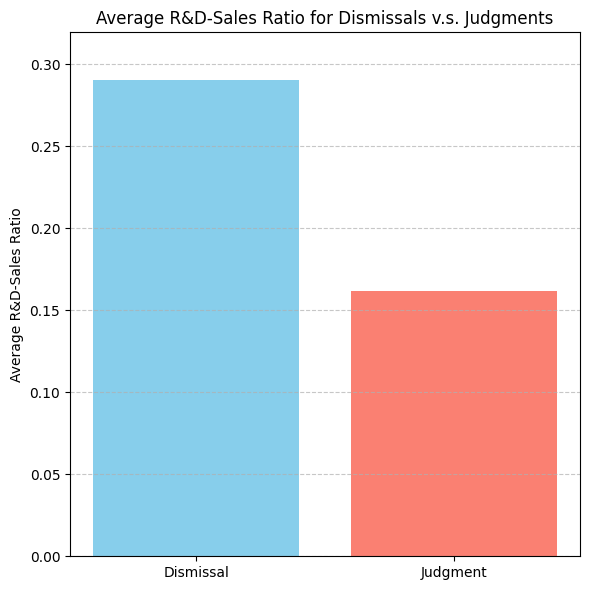

In [55]:
avg_dismissal = rnd[rnd['disp_dismissed'] == 1]['closed_plus_1_rd_sale'].mean()
avg_judgment = rnd[rnd['disp_judgment'] == 1]['closed_plus_1_rd_sale'].mean()

# Values and labels
means = [avg_dismissal, avg_judgment]
labels = ['Dismissal', 'Judgment']

# Create the bar chart
plt.figure(figsize=(6, 6))
plt.bar(labels, means, color=['skyblue', 'salmon'])
plt.ylabel('Average R&D-Sales Ratio')
plt.title('Average R&D-Sales Ratio for Dismissals v.s. Judgments')
plt.ylim(0, max(means) * 1.1)  # Add some space above bars for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [56]:
!pip install wrds

In [57]:
# Import the library
import wrds

# Connect to WRDS
db = wrds.Connection()

# Test the connection: list available libraries
db.list_libraries()

Enter your WRDS username [root]:sai047
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


['aha_sample',
 'ahasamp',
 'audit',
 'audit_acct_os',
 'audit_audit_comp',
 'audit_common',
 'audit_corp_legal',
 'auditsmp',
 'auditsmp_all',
 'bank',
 'bank_all',
 'bank_premium',
 'bank_premium_samp',
 'banksamp',
 'block',
 'block_all',
 'boardex',
 'boardex_na',
 'boardex_trial',
 'boardsmp',
 'bvd_amadeus_trial',
 'bvd_bvdbankf_trial',
 'bvd_orbis_trial',
 'bvdsamp',
 'calcbench_trial',
 'calcbnch',
 'candid_samp',
 'cboe',
 'cboe_all',
 'cboe_sample',
 'cboesamp',
 'cddsamp',
 'ciq',
 'ciq_common',
 'ciq_pplintel',
 'ciq_ratings',
 'ciqsamp',
 'ciqsamp_capstrct',
 'ciqsamp_common',
 'ciqsamp_keydev',
 'ciqsamp_pplintel',
 'ciqsamp_ratings',
 'ciqsamp_transactions',
 'ciqsamp_transcripts',
 'cisdmsmp',
 'columnar',
 'comp',
 'comp_bank_daily',
 'comp_execucomp',
 'comp_na_daily_all',
 'comp_pit',
 'comp_segments_hist_daily',
 'comp_snapshot',
 'comph',
 'compsamp',
 'compsamp_all',
 'compsamp_snapshot',
 'compseg',
 'compsnap',
 'contrib',
 'contrib_as_filed_financials',
 'contr

In [143]:
data = rnd.merge(npm[['case_number', 'defendant','filed_minus_1_npm', 'closed_plus_1_npm']],
                 on=['case_number', 'defendant'], how='left')
data = data.drop_duplicates()

import pandas as pd
import numpy as np

# Ensure datetime format
data['date_closed'] = pd.to_datetime(data['date_closed'])
data['date_filed'] = pd.to_datetime(data['date_filed'])

# Create 'quarter_before_closing' and 'quarter_after_closing'
data['quarter_before_filing'] = (data['date_filed'] - pd.offsets.QuarterEnd(1)).dt.to_period('Q')
data['quarter_after_closing'] = (data['date_closed'] + pd.offsets.QuarterEnd(1)).dt.to_period('Q')

# Get unique gvkeys from your 'data' DataFrame
unique_gvkeys = data['gvkey'].unique().tolist()

data

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,past_performance,filed_minus_1_npm,closed_plus_1_npm,quarter_before_filing,quarter_after_closing
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0,0.115615,0.208424,0.226309,2011Q3,2015Q1
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0,0.055669,-0.038337,0.796015,2015Q1,2017Q2
2,5:11-cv-01349,0.000000,0.000000,0.000000,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,0.000000,0.051389,0.047465,2011Q1,2012Q3
3,2:87-cv-00979,0.000000,0.000000,0.000000,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,11,26,26.2,-8,88888,0,1,0,0,1,0,0,0,0,0,0,0,0.000000,0.011557,0.037153,1987Q1,1989Q3
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0,0.046975,0.207433,0.210924,2017Q1,2017Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,3:97-cv-00860,0.083717,0.089442,0.005725,WI,2,0,0,0,1,0,50230.0,1997-12-18,1998-03-12,NaN,23045,0.083717,0.089442,0.079640,0.069746

In [151]:
import wrds
import pandas as pd

# Prepare gvkey list
unique_gvkeys = data['gvkey'].astype(str).unique().tolist()
gvkey_tuple = tuple(unique_gvkeys)
if len(gvkey_tuple) == 1:
    gvkey_tuple = (gvkey_tuple[0],)  # ensure tuple

# Final correct query
query = f"""
    SELECT gvkey, qdate, curr_ratio, roa
    FROM wrdsapps_finratio.firm_ratio
    WHERE gvkey IN {gvkey_tuple}
      AND qdate BETWEEN '1970-01-01' AND '2022-12-31'
"""

# Execute and prep
df_ratios = conn.raw_sql(query, date_cols=['qdate'])
df_ratios['quarter'] = df_ratios['qdate'].dt.to_period('Q')

In [152]:
df_ratios

,gvkey,qdate,curr_ratio,roa,quarter
0,106228,1998-03-31,2.956739,-4.078878,1998Q1
1,106228,1998-03-31,2.956739,-4.078878,1998Q1
2,106228,1998-03-31,2.956739,-4.078878,1998Q1
3,106228,1998-06-30,4.775233,-0.242313,1998Q2
4,106228,1998-06-30,4.775233,-0.242313,1998Q2
...,...,...,...,...,...
40643,289735,2022-09-30,7.029378,-0.162169,2022Q3
40644,289735,2022-09-30,7.029378,-0.162169,2022Q3
40645,289735,2022-12-31,7.155587,-0.19989,2022Q4
40646,289735,2022-12-31,7.155587,-0.19989,2022Q4


In [148]:
data['gvkey'] = data['gvkey'].astype(str)
df_ratios['gvkey'] = df_ratios['gvkey'].astype(str)
temp = data.merge(df_ratios, left_on=['gvkey', 'quarter_after_closing'],right_on=['gvkey', 'qdate'], how='left')
temp = temp.drop_duplicates()
temp = temp.drop(columns=['qdate'])
temp

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,past_performance,filed_minus_1_npm,closed_plus_1_npm,quarter_before_filing,quarter_after_closing,curr_ratio,roa,quarter
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0,0.115615,0.208424,0.226309,2011Q3,2015Q1,<NA>,<NA>,NaT
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0,0.055669,-0.038337,0.796015,2015Q1,2017Q2,<NA>,<NA>,NaT
2,5:11-cv-01349,0.000000,0.000000,0.000000,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,0.000000,0.051389,0.047465,2011Q1,2012Q3,<NA>,<NA>,NaT
3,2:87-cv-00979,0.000000,0.000000,0.000000,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,11,26,26.2,-8,88888,0,1,0,0,1,0,0,0,0,0,0,0,0.000000,0.011557,0.037153,1987Q1,1989Q3,<NA>,<NA>,NaT
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0,0.046975,0.207433,0.210924,2017Q1,2017Q3,<NA>,<NA>,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,3:97-cv-00860,0.083717,0.0

In [37]:
rnd.columns

Index(['case_number', 'filing_quarter_rnd', 'closing_quarter_rnd',
       'delta_rnd_sales', 'state_province', 'case_length', 'materials',
       'industrials', 'consumer_discretionary', 'info_tech', 'health_care',
       'case_row_id', 'date_filed', 'date_closed', 'DEF_x', 'gvkey',
       'filing_rd_sale', 'closing_rd_sale', 'filed_minus_1_rd_sale',
       'filed_minus_2_rd_sale', 'filed_minus_3_rd_sale',
       'filed_minus_4_rd_sale', 'filed_minus_5_rd_sale',
       'filed_minus_6_rd_sale', 'filed_minus_7_rd_sale',
       'filed_minus_8_rd_sale', 'filed_minus_9_rd_sale',
       'filed_minus_10_rd_sale', 'closed_plus_1_rd_sale',
       'closed_plus_2_rd_sale', 'closed_plus_3_rd_sale',
       'closed_plus_4_rd_sale', 'closed_plus_5_rd_sale',
       'closed_plus_6_rd_sale', 'closed_plus_7_rd_sale',
       'closed_plus_8_rd_sale', 'closed_plus_9_rd_sale',
       'closed_plus_10_rd_sale', 'defendant', 'PLT_x', 'plaintiff',
       'quarter_filed', 'quarter_closed', 'case_name', 'PLT_y', '

# Fitting Baseline Regression Models (Not Causal)


In [ ]:
!pip install stargazer
import stargazer
import statsmodels.formula.api as smf
from IPython.display import HTML
from stargazer.stargazer import Stargazer

In [ ]:
rnd.columns

Index(['case_number', 'filing_quarter_rnd', 'closing_quarter_rnd',
       'delta_rnd_sales', 'state_province', 'case_length', 'materials',
       'industrials', 'consumer_discretionary', 'info_tech', 'health_care',
       'case_row_id', 'date_filed', 'date_closed', 'DEF_x', 'gvkey',
       'filing_rd_sale', 'closing_rd_sale', 'filed_minus_1_rd_sale',
       'filed_minus_2_rd_sale', 'filed_minus_3_rd_sale',
       'filed_minus_4_rd_sale', 'filed_minus_5_rd_sale',
       'filed_minus_6_rd_sale', 'filed_minus_7_rd_sale',
       'filed_minus_8_rd_sale', 'filed_minus_9_rd_sale',
       'filed_minus_10_rd_sale', 'closed_plus_1_rd_sale',
       'closed_plus_2_rd_sale', 'closed_plus_3_rd_sale',
       'closed_plus_4_rd_sale', 'closed_plus_5_rd_sale',
       'closed_plus_6_rd_sale', 'closed_plus_7_rd_sale',
       'closed_plus_8_rd_sale', 'closed_plus_9_rd_sale',
       'closed_plus_10_rd_sale', 'defendant', 'PLT_x', 'plaintiff',
       'quarter_filed', 'quarter_closed', 'case_name', 'PLT_y', '

In [ ]:
# Regression Table 1: Heterogeniety between Defendants and Plaintiffs (Dismissals)

#base model
model_1 = smf.ols('closed_plus_1_rd_sale ~ disp_dismissed', data=rnd).fit()

#adds covariates
model_2 = smf.ols('closed_plus_1_rd_sale ~ disp_dismissed + disp_judgment + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#adds more controls for type of dismissal and
model_3 = smf.ols('closed_plus_1_rd_sale ~ disp_dismissed + disp_dismissed:defendant + disp_judgment + disp_dismissed:dismissed_settlement + disp_dismissed:dismissed_voluntary + disp_dismissed:disp_before_issue_joined + filed_minus_1_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#plaintiff-defendant heterogeniety
model_4 = smf.ols('closed_plus_1_rd_sale ~ disp_dismissed + disp_dismissed:defendant + disp_judgment + disp_judgment:judgment_favor_plt + disp_judgment:judgment_favor_def + disp_dismissed:dismissed_settlement + disp_dismissed:dismissed_voluntary + disp_dismissed:disp_before_issue_joined + filed_minus_1_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#creating stargazer object
stargazer = Stargazer([model_1, model_2, model_3, model_4])

# Custom column names
stargazer.custom_columns(["Model 1", 'Model 2', 'Model 3', 'Model 4'], [1, 1, 1, 1])


stargazer.covariate_order(['Intercept', 'disp_dismissed', 'disp_dismissed:defendant',
                           'disp_dismissed:dismissed_settlement',
                           'disp_dismissed:dismissed_voluntary', 'disp_dismissed:disp_before_issue_joined',
                           'disp_judgment', 'disp_judgment:judgment_favor_plt',
                           'disp_judgment:judgment_favor_def',
                           'filed_minus_1_rd_sale', 'case_length', 'info_tech',
                           'health_care', 'industrials', 'materials', 'consumer_discretionary'])


stargazer.rename_covariates({'disp_dismissed': 'Case Dismised', 'disp_dismissed:defendant': 'Case Dismissed:Defendant',
                             'disp_judgment': 'Case went to Judgment', 'disp_judgment:judgment_favor_plt': 'Judgment:Plaintiff Wins',
                             'disp_judgment:judgment_favor_def': 'Judgment:Defendant Wins',
                             'disp_dismissed:dismissed_settlement': 'Case Dismissed:Settlement',
                             'disp_dismissed:dismissed_voluntary': 'Case Dismissed:Voluntary Withdarwal',
                             'disp_dismissed:disp_before_issue_joined': 'Case Dismissed Before Issue Joineder',
                             'filed_minus_1_rd_sale': 'Lagged R&D to Sales Ratio (One Quarter Before Case Filing)',
                             'case length': 'Case Length in Number of Fin. Quarters',
                             'info_tech': 'IT Sector', 'health_care': 'Health Care Sector',
                             'industrials': 'Industrials Sector', 'materials': 'Materials Sector',
                             'consumer_discretionary': 'Consumer Discretionary Sector',
                             'case_length': 'Case Length in Number of Quarters'})

stargazer.title("Esimated effect of Case Dismissals on Firms' R&D to Sales Ratios")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

# Save the Stargazer HTML table to file
with open("regression_table.html", "w") as f:
    f.write(stargazer.render_html())

# Download the file to your local machine
from google.colab import files
files.download("regression_table.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Using LegalBERT to extract Instrument from Text

In [ ]:
cases = list(set(rnd['case_number']).intersection(set(npm['case_number'])))
matched_documents = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/matched_documents.csv')

In [ ]:
#list of words to be filtered out
excluded_words = [
    "damage", "fine", "compensation", "settlement", "award", "restitution",
    "penalty", "cost", "sanction", "remedy", "reimbursement", "indemnity", "liability",
    "fee", "expense", "attorney fee", "legal fee", "court cost", "filing fee", "litigation cost",
    "settle", "compel", "impose", "enforce", "assess",
    "profit", "loss", "revenue", "sale", "earning", "investment", "valuation",
    "shareholder", "dividend", "stock", "merger", "acquisition", "order",
    "judgment", "case closed", "closed", "dismissed", "transferred out",
    "transferred", "magistrate", "attorney", "judge", "order", "judgment"
]

#loading spacy english model
import spacy
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

exlcuded_wrods = [lemmatize_text(word)for word in excluded_words]

In [ ]:
import re
# Construct regex pattern for excluded words
pattern = r'\b(' + '|'.join(re.escape(word) for word in excluded_words) + r')\b'

# Filter matched_docs for rows that do NOT contain excluded words
no_order_judgment = matched_documents[
    ~matched_documents['cleaned_text'].str.contains(pattern, regex=True, case=False, na=False)
]

# Apply the same exclusion filter on no_order_judgment
no_order_judgment = no_order_judgment[
    ~no_order_judgment['long_description'].str.contains(pattern, regex=True, case=False, na=False)
]

# Remove "(Entered: MM/DD/YYYY)" pattern
no_order_judgment['long_description'] = no_order_judgment['long_description'].str.replace(
    r"\(Entered: \d{2}/\d{2}/\d{4}\)", "", regex=True
)

# Remove standalone dates (MM/DD/YYYY)
no_order_judgment['long_description'] = no_order_judgment['long_description'].str.replace(
    r"\b\d{2}/\d{2}/\d{4}\b", "", regex=True
)

In [ ]:
no_order_judgment

,case_row_id,case_number,case_number_raw,district_id,doc_count,doc_number,short_description,long_description,attachment,doc_date_filed,doc_date_uploaded,document_url,cleaned_text
0,22.0,0:87-cv-06504,0:87-cv-06504-JLK,flsd,1,9.0,NaN,COPY OF PAPER DOCKET SHEET (Former Deputy Clerk),NaN,2003-05-02,NaN,NaN,copy paper docket sheet deputy clerk enter 05/...
5,43.0,0:90-cv-04396,0:90-cv-04396-LDW-DFJ,nyed,5,24.0,NaN,LTR. dtd. 10/9/91 to Wexler from Robert Wagner...,NaN,1991-10-11,NaN,NaN,ltr dtd 10/9/91 wexler robert wagner response ...
6,43.0,0:90-cv-04396,0:90-cv-04396-LDW-DFJ,nyed,6,23.0,NaN,LTR. dtd. 10/1/91 to Wexler from Richard Himel...,NaN,1991-10-11,NaN,NaN,ltr dtd 10/1/91 wexler richard himelhoch rober...
7,43.0,0:90-cv-04396,0:90-cv-04396-LDW-DFJ,nyed,7,22.0,NaN,"REPLY by K.I.C. Corp., Triad Electric in oppos...",NaN,1991-10-07,NaN,NaN,reply k.i.c. corp. triad electric opposition m...
10,43.0,0:90-cv-04396,0:90-cv-04396-LDW-DFJ,nyed,10,20.0,NaN,"REPLY by LittleFuse, Inc. in response to defts...",NaN,1991-10-03,NaN,NaN,reply littlefuse inc. response deft opposition...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
984502,103265.0,4:13-cv-04201,4:13-cv-04201-PJH,cand,377,150.0,NaN,CLERK'S NOTICE OF CONTINUANCE OF CASE MANAGEME...,NaN,2015-09-04,2015-09-04,NaN,clerk notice continuance case management confe...
984506,103265.0,4:13-cv-04201,4:13-cv-04201-PJH,cand,381,154.0,NaN,NOTICE OF APPEAL to the Federal Circuit by Ev...,NaN,2015-11-04,2015-11-04,https://ecf.cand.uscourts.gov/doc1/035113541695,notice appeal federal circuit evolutionary int...
984508,103265.0,4:13-cv-04201,4:13-cv-04201-PJH,cand,383,156.0,NaN,USCA Case Number 16-1190 as to 154 Notice of...,NaN,2015-11-12,2015-11-12,https://ecf.cand.uscourts.gov/doc1/035113566254,usca case number notice appeal federal circuit...
984509,103265.0,4:13-cv-04201,4:13-cv-04201-PJH,cand,384,156.0,NaN,missing a description,1.0,NaN,NaN,https://ecf.cand.uscourts.gov/doc1/035113541695,miss description


In [ ]:
BERT_Training = no_order_judgment.groupby('case_number')['long_description'].agg(' '.join).reset_index()
BERT_Training = BERT_Training.merge(rnd[['case_number', 'disp_dismissed']], on='case_number', how='left')
BERT_Training = BERT_Training.drop_duplicates()
BERT_Training = BERT_Training.dropna()

In [ ]:
BERT_Training

,case_number,long_description,disp_dismissed
1,0:10-cv-03601,NOTICE of Filing of Official Transcript. (jma)...,0.0
2,0:10-cv-03989,*TEXT ONLY ENTRY* NOTICE of Cancellation of Mo...,1.0
3,0:10-cv-60674,"Clerks Notice to Filer re 42 Stipulation,. Wro...",0.0
4,0:10-cv-60677,REPLY to Response to Motion re 27 MOTION to Tr...,0.0
6,0:11-cv-00569,missing a description missing a description mi...,1.0
...,...,...,...
8177,9:19-cv-80169,missing a description missing a description mi...,1.0
8178,9:90-cv-00855,"SEALED DOCUMENT placed in vault (Best, Trish) ...",0.0
8184,9:93-cv-08339,"NOTICE of motion, motion and memorandum in sup...",1.0
8192,9:98-cv-04877,"LETTER dated 3/17/00 from Joseph D. Garon, Esq...",1.0


In [ ]:
from sklearn.model_selection import StratifiedKFold

# 5‑fold CV, shuffling for randomness but reproducible with the seed
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []        # we’ll append a dict of indices for each fold

for fold_id, (train_idx, val_idx) in enumerate(
        skf.split(BERT_Training["long_description"], BERT_Training["disp_dismissed"])):

    folds.append({"train_idx": train_idx, "val_idx": val_idx})

    # quick sanity‑check: class balance in each partition
    train_ratio = BERT_Training["disp_dismissed"].iloc[train_idx].mean()
    val_ratio   = BERT_Training["disp_dismissed"].iloc[val_idx].mean()

    print(f"Fold {fold_id} → "
          f"train: {len(train_idx):4d} samples  (mean label = {train_ratio:.2f})   |  "
          f"val: {len(val_idx):4d} samples  (mean label = {val_ratio:.2f})")


Fold 0 → train: 3137 samples  (mean label = 0.73)   |  val:  785 samples  (mean label = 0.74)
Fold 1 → train: 3137 samples  (mean label = 0.73)   |  val:  785 samples  (mean label = 0.74)
Fold 2 → train: 3138 samples  (mean label = 0.73)   |  val:  784 samples  (mean label = 0.73)
Fold 3 → train: 3138 samples  (mean label = 0.73)   |  val:  784 samples  (mean label = 0.73)
Fold 4 → train: 3138 samples  (mean label = 0.73)   |  val:  784 samples  (mean label = 0.73)


In [ ]:
from datasets import Dataset, DatasetDict, Value
from transformers import AutoTokenizer

# load LegalBERT tokenizer once
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenised_folds = []   # will mirror the structure of `folds`

for fold_id, idx_dict in enumerate(folds):
    train_idx, val_idx = idx_dict["train_idx"], idx_dict["val_idx"]

    # build plain python lists first
    train_texts  = BERT_Training["long_description"].iloc[train_idx].tolist()
    train_labels = BERT_Training["disp_dismissed"].iloc[train_idx].tolist()
    val_texts    = BERT_Training["long_description"].iloc[val_idx].tolist()
    val_labels   = BERT_Training["disp_dismissed"].iloc[val_idx].tolist()

    # wrap in HF Datasets, cast label to int64, then tokenize
    dsets = DatasetDict({
        "train":      Dataset.from_dict({"text": train_texts, "label": train_labels}),
        "validation": Dataset.from_dict({"text": val_texts,   "label": val_labels})
    }).cast_column("label", Value("int64")).map(tokenize, batched=True)

    tokenised_folds.append(dsets)
    print(f"Fold {fold_id} tokenised ➜ "
          f"{len(train_texts)} training rows | {len(val_texts)} validation rows")


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/v

Casting the dataset:   0%|          | 0/3137 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/785 [00:00<?, ? examples/s]

Map:   0%|          | 0/3137 [00:00<?, ? examples/s]

Map:   0%|          | 0/785 [00:00<?, ? examples/s]

Fold 0 tokenised ➜ 3137 training rows | 785 validation rows


Casting the dataset:   0%|          | 0/3137 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/785 [00:00<?, ? examples/s]

Map:   0%|          | 0/3137 [00:00<?, ? examples/s]

Map:   0%|          | 0/785 [00:00<?, ? examples/s]

Fold 1 tokenised ➜ 3137 training rows | 785 validation rows


Casting the dataset:   0%|          | 0/3138 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/3138 [00:00<?, ? examples/s]

Map:   0%|          | 0/784 [00:00<?, ? examples/s]

Fold 2 tokenised ➜ 3138 training rows | 784 validation rows


Casting the dataset:   0%|          | 0/3138 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/3138 [00:00<?, ? examples/s]

Map:   0%|          | 0/784 [00:00<?, ? examples/s]

Fold 3 tokenised ➜ 3138 training rows | 784 validation rows


Casting the dataset:   0%|          | 0/3138 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/3138 [00:00<?, ? examples/s]

Map:   0%|          | 0/784 [00:00<?, ? examples/s]

Fold 4 tokenised ➜ 3138 training rows | 784 validation rows


In [ ]:
import os, torch, pandas as pd, numpy as np
from sklearn.model_selection import StratifiedKFold
from datasets import Dataset, DatasetDict, Value
from torch.nn import CrossEntropyLoss, functional as F
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, logging
)

# ── Setup ────────────────────────────────────────────────────────────────
logging.set_verbosity_info()
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"]     = "offline"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

# Container for all out‑of‑sample results
results = []

# ── Stratified 5‑fold loop ───────────────────────────────────────────────
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold_id, (train_idx, val_idx) in enumerate(
        skf.split(BERT_Training["long_description"], BERT_Training["disp_dismissed"])):

    print(f"\n=== Fold {fold_id+1}/5 ===")

    # ---- Prepare HF datasets for this fold ----
    train_texts  = BERT_Training["long_description"].iloc[train_idx].tolist()
    train_labels = BERT_Training["disp_dismissed"].iloc[train_idx].tolist()
    val_texts    = BERT_Training["long_description"].iloc[val_idx].tolist()
    val_labels   = BERT_Training["disp_dismissed"].iloc[val_idx].tolist()
    val_ids      = BERT_Training["case_number"].iloc[val_idx].tolist()

    dsets = DatasetDict({
        "train":      Dataset.from_dict({"text": train_texts, "label": train_labels}),
        "validation": Dataset.from_dict({"text": val_texts,   "label": val_labels})
    }).cast_column("label", Value("int64")) \
     .map(lambda b: tokenizer(b["text"], padding="max_length", truncation=True, max_length=512), batched=True)

    # ---- Compute class weights for this fold ----
    n0 = train_labels.count(0)
    n1 = train_labels.count(1)
    total = n0 + n1
    class_weights = torch.tensor([ total/(2*n0), total/(2*n1) ], dtype=torch.float)

    # ---- Instantiate model & Trainer ----
    model = AutoModelForSequenceClassification.from_pretrained(
        "nlpaueb/legal-bert-base-uncased", num_labels=2
    )
    model.config.hidden_dropout_prob          = 0.1
    model.config.attention_probs_dropout_prob = 0.1
    model.config.problem_type = "single_label_classification"
    model.to(device)

    # custom Trainer to apply weighted CE loss
    class WeightedTrainer(Trainer):
        def __init__(self, cw, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.loss_fn = CrossEntropyLoss(weight=cw.to(self.args.device))
        def compute_loss(self, m, inputs, return_outputs=False, **kwargs):
            labels = inputs.pop("labels")
            outs   = m(**inputs)
            loss   = self.loss_fn(outs.logits, labels)
            return (loss, outs) if return_outputs else loss

    args = TrainingArguments(
        output_dir              = f"./tmp_fold_{fold_id}",
        eval_strategy     = "epoch",
        save_strategy           = "no",
        per_device_train_batch_size = 16,
        per_device_eval_batch_size  = 16,
        num_train_epochs        = 3,
        learning_rate           = 2e-5,
        weight_decay            = 0.01,
        logging_steps           = 10,
        seed                    = 42
    )

    trainer = WeightedTrainer(
        cw=class_weights,
        model          = model,
        args           = args,
        train_dataset  = dsets["train"],
        eval_dataset   = dsets["validation"],
        tokenizer      = tokenizer
    )

    # ---- Train & predict on the held‑out fold ----
    trainer.train()
    preds = trainer.predict(dsets["validation"])
    logits = preds.predictions                     # shape [N,2]
    probs  = F.softmax(torch.tensor(logits), dim=1).numpy()
    cls    = probs.argmax(axis=1)

    # ---- Collect only out‑of‑sample rows ----
    for i, cid in enumerate(val_ids):
        results.append({
            "case_number":     cid,
            "true_label":      int(val_labels[i]),
            "predicted_label": int(cls[i]),
            "probability":     float(probs[i,1]),
            "logits":          logits[i].tolist()
        })

# ── Done ─────────────────────────────────────────────────────────────────
results_df = pd.DataFrame(results)
display(results_df.head())


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/v


=== Fold 1/5 ===


Casting the dataset:   0%|          | 0/3137 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/785 [00:00<?, ? examples/s]

Map:   0%|          | 0/3137 [00:00<?, ? examples/s]

Map:   0%|          | 0/785 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167d

Epoch,Training Loss,Validation Loss
1,0.669900,0.611689
2,0.521300,0.533231
3,0.532200,0.526767


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 785
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 785
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 785
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this 


=== Fold 2/5 ===


Casting the dataset:   0%|          | 0/3137 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/785 [00:00<?, ? examples/s]

Map:   0%|          | 0/3137 [00:00<?, ? examples/s]

Map:   0%|          | 0/785 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167d

Epoch,Training Loss,Validation Loss
1,0.646800,0.616697
2,0.548000,0.567585
3,0.503000,0.593425


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 785
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 785
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 785
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this 


=== Fold 3/5 ===


Casting the dataset:   0%|          | 0/3138 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/3138 [00:00<?, ? examples/s]

Map:   0%|          | 0/784 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167d

Epoch,Training Loss,Validation Loss
1,0.610400,0.627410
2,0.574900,0.571675
3,0.542100,0.590084


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this 


=== Fold 4/5 ===


Casting the dataset:   0%|          | 0/3138 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/3138 [00:00<?, ? examples/s]

Map:   0%|          | 0/784 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167d

Epoch,Training Loss,Validation Loss
1,0.613100,0.637456
2,0.609100,0.558660
3,0.488700,0.570466


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this 


=== Fold 5/5 ===


Casting the dataset:   0%|          | 0/3138 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/3138 [00:00<?, ? examples/s]

Map:   0%|          | 0/784 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167d

Epoch,Training Loss,Validation Loss
1,0.697300,0.697698
2,0.724300,0.691839
3,0.681600,0.695221


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 784
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this 

,case_number,true_label,predicted_label,probability,logits
0,0:10-cv-03601,0,0,0.468327,"[-0.10482322424650192, -0.23168398439884186]"
1,0:10-cv-60677,0,0,0.089311,"[1.1535605192184448, -1.1685115098953247]"
2,0:11-cv-00789,0,1,0.874712,"[-1.0103626251220703, 0.9329196214675903]"
3,0:12-cv-00618,1,1,0.957360,"[-1.6118897199630737, 1.499491572380066]"
4,0:12-cv-61268,1,1,0.938795,"[-1.3541978597640991, 1.376171350479126]"


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1️⃣ Evaluate out‑of‑sample performance
y_true = results_df["true_label"]
y_pred = results_df["predicted_label"]

print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))

# 2️⃣ Merge predictions back into your original DataFrame
merged = BERT_Training.merge(
    results_df,
    on="case_number",
    how="left"
)

# Display first few rows to confirm
display(merged.head())


Accuracy : 0.6361550229474757
Precision: 0.8433223218499292
Recall   : 0.6200555170020818
F1 Score : 0.7146570685862828


,case_number,long_description,disp_dismissed,true_label,predicted_label,probability,logits
0,0:10-cv-03601,NOTICE of Filing of Official Transcript. (jma)...,0.0,0,0,0.468327,"[-0.10482322424650192, -0.23168398439884186]"
1,0:10-cv-03989,*TEXT ONLY ENTRY* NOTICE of Cancellation of Mo...,1.0,1,1,0.915240,"[-1.3029381036758423, 1.076421856880188]"
2,0:10-cv-60674,"Clerks Notice to Filer re 42 Stipulation,. Wro...",0.0,0,0,0.269445,"[0.6235454082489014, -0.37389734387397766]"
3,0:10-cv-60677,REPLY to Response to Motion re 27 MOTION to Tr...,0.0,0,0,0.089311,"[1.1535605192184448, -1.1685115098953247]"
4,0:11-cv-00569,missing a description missing a description mi...,1.0,1,0,0.482535,"[0.0499265156686306, -0.019961180165410042]"


In [ ]:
merged["logit_margin"] = merged["logits"].apply(lambda x: x[1] - x[0])

In [ ]:
merged

,case_number,long_description,disp_dismissed,true_label,predicted_label,probability,logits,logit_margin
0,0:10-cv-03601,NOTICE of Filing of Official Transcript. (jma)...,0.0,0,0,0.468327,"[-0.10482322424650192, -0.23168398439884186]",-0.126861
1,0:10-cv-03989,*TEXT ONLY ENTRY* NOTICE of Cancellation of Mo...,1.0,1,1,0.915240,"[-1.3029381036758423, 1.076421856880188]",2.379360
2,0:10-cv-60674,"Clerks Notice to Filer re 42 Stipulation,. Wro...",0.0,0,0,0.269445,"[0.6235454082489014, -0.37389734387397766]",-0.997443
3,0:10-cv-60677,REPLY to Response to Motion re 27 MOTION to Tr...,0.0,0,0,0.089311,"[1.1535605192184448, -1.1685115098953247]",-2.322072
4,0:11-cv-00569,missing a description missing a description mi...,1.0,1,0,0.482535,"[0.0499265156686306, -0.019961180165410042]",-0.069888
...,...,...,...,...,...,...,...,...
3917,9:19-cv-80169,missing a description missing a description mi...,1.0,1,1,0.947997,"[-1.4054104089736938, 1.4976474046707153]",2.903058
3918,9:90-cv-00855,"SEALED DOCUMENT placed in vault (Best, Trish) ...",0.0,0,0,0.482534,"[0.049928583204746246, -0.019965466111898422]",-0.069894
3919,9:93-cv-08339,"NOTICE of motion, motion and memorandum in sup...",1.0,1,1,0.675041,"[-0.5929869413375854, 0.1380854994058609]",0.731072
3920,9:98-cv-04877,"LETTER dated 3/17/00 from Joseph D. Garon, Esq...",1.0,1,0,0.482532,"[0.04993114247918129, -0.019969722256064415]",-0.069901


In [ ]:
merged.to_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/cross_fit_BERT_Predictions.csv')

# Fitting Text-Instrument Models (2sls and IV Causal Forrests)

In [ ]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
cross_fit_BERT_Predictions = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/cross_fit_BERT_Predictions.csv')
cross_fit_BERT_Predictions['logits'] = cross_fit_BERT_Predictions['logits'][1]

In [ ]:
rnd_iv = rnd.merge(cross_fit_BERT_Predictions[['case_number', 'predicted_label', 'probability', 'logits', 'logit_margin']], on='case_number', how='left')
rnd_iv = rnd_iv[rnd_iv['logit_margin'].notna()]

npm_iv = npm.merge(cross_fit_BERT_Predictions[['case_number', 'predicted_label', 'probability', 'logits', 'logit_margin']], on='case_number', how='left')
npm_iv = npm_iv[npm_iv['logit_margin'].notna()]

In [ ]:
npm_iv.head()

,case_number,filing_quarter_npm,closing_quarter_npm,delta_npm,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_npm,closing_npm,filed_minus_1_npm,filed_minus_2_npm,filed_minus_3_npm,filed_minus_4_npm,filed_minus_5_npm,filed_minus_6_npm,filed_minus_7_npm,filed_minus_8_npm,filed_minus_9_npm,filed_minus_10_npm,closed_plus_1_npm,closed_plus_2_npm,closed_plus_3_npm,closed_plus_4_npm,closed_plus_5_npm,closed_plus_6_npm,closed_plus_7_npm,closed_plus_8_npm,closed_plus_9_npm,closed_plus_10_npm,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,FED_QUESTION,US_DEF,US_PLT,past_performance,predicted_label,probability,logits,logit_margin
0,2:11-cv-01037,0.163247,0.226309,0.063062,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.163247,0.226309,0.208424,0.222403,0.228644,0.231133,0.218727,0.208168,0.182834,0.140980,0.093009,0.090787,0.226309,0.228330,0.227446,0.229692,0.236506,0.245290,0.257436,0.268886,0.281967,0.290327,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.222651,1.0,0.670256,"[-1.3029381036758423, 1.076421856880188]",0.709344
1,1:15-cv-01059,0.244910,0.796015,0.551105,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.244910,0.796015,-0.038337,0.002570,0.177977,0.177977,0.177977,0.177977,0.177692,0.177340,0.186757,0.185404,0.796015,0.783359,-0.105780,-0.160819,-0.098993,-0.078669,0.235250,0.249267,0.235700,0.195106,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0.080047,1.0,0.527364,"[-1.3029381036758423, 1.076421856880188]",0.109567
2,5:11-cv-01349,0.051063,0.047465,-0.003598,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.051063,0.047465,0.051389,0.052812,0.056058,0.059108,0.050739,0.038591,0.021813,0.017965,0.022998,0.030151,0.047465,0.066061,0.066351,0.069411,0.071422,0.050828,0.055643,0.055991,0.050594,0.058694,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0.054842,0.0,0.298427,"[-1.3029381036758423, 1.076421856880188]",-0.854801
4,1:17-cv-00179,0.208723,0.210924,0.002201,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.208723,0.210924,0.207433,0.207305,0.212408,0.217516,0.223264,0.229189,0.228458,0.226164,0.225335,0.222533,0.210924,0.211246,0.215499,0.220046,0.224341,0.227377,0.221371,0.215010,0.212381,0.214907,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0.211165,0.0,0.215751,"[-1.3029381036758423, 1.076421856880188]",-1.290601
5,4:13-cv-00342,0.272873,0.193822,-0.079052,CA,4,0,0,0,0,0,62893.0,2013-06-05,2014-02-21,ACTIVISION BLIZZARD INC,180405,0.272873,0.193822,0.243810,0.236614,0.198888,0.185160,0.215721,0.228181,0.157663,0.137613,0.117698,0.093996,0.193822,0.169503,0.148701,0.189428,0.204590,0.203054,0.223859,0.191252,0.177856,0.149031,1.0,NaN,0.0,2013Q2,2014Q1,P S Products Inc et al v. Activision Blizzard ...,"P S PRODUCTS INC, ET AL","ACTIVISION BLIZZARD INC, ET AL",8,60,60.4,P,5001,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0.216118,0.0,0.482531,"[-1.3029381036758423, 1.076421856880188]",-0.069902


In [ ]:
rnd_iv.head()

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,past_performance,predicted_label,probability,logits,logit_margin
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0,0.115615,1.0,0.670256,"[-1.3029381036758423, 1.076421856880188]",0.709344
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0,0.055669,1.0,0.527364,"[-1.3029381036758423, 1.076421856880188]",0.109567
2,5:11-cv-01349,0.000000,0.000000,0.000000,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,0.000000,0.0,0.298427,"[-1.3029381036758423, 1.076421856880188]",-0.854801
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0,0.046975,0.0,0.215751,"[-1.3029381036758423, 1.076421856880188]",-1.290601
5,4:13-cv-00342,0.118780,0.137757,0.018977,CA,4,0,0,0,0,0,62893.0,2013-06-05,2014-02-21,ACTIVISION BLIZZARD INC,180405,0.118780,0.137757,0.122804,0.124382,0.141935,0.146812,0.138008,0.135857,0.139447,0.136983,0.139712,0.144367,0.137757,0.138028,0.134222,0.129537,0.125246,0.131211,0.130346,0.138508,0.139641,0.144560,1.0,NaN,0.0,2013Q2,2014Q1,P S Products Inc et al v. Activision Blizzard ...,"P S PRODUCTS INC, ET AL","ACTIVISION BLIZZARD INC, ET AL",8,60,60.4,P,5001,1,0,1,0,0,0,0,1,0,0,0,0,0.133983,0.0,0.482531,"[-1.3029381036758423, 1.076421856880188]",-0.069902


In [ ]:
from linearmodels.iv import IV2SLS

rnd_iv_model_1 = IV2SLS.from_formula("closed_plus_1_rd_sale ~  dismissed_settlement + dismissed_voluntary + disp_before_issue_joined  + filed_minus_1_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary[disp_dismissed ~ probability]",data=rnd_iv).fit(debiased=True)

print(rnd_iv_model_1.summary)

                            IV-2SLS Estimation Summary                           
Dep. Variable:     closed_plus_1_rd_sale   R-squared:                      0.9971
Estimator:                       IV-2SLS   Adj. R-squared:                 0.9971
No. Observations:                   3980   F-statistic:                 6.965e+04
Date:                   Fri, Apr 25 2025   P-value (F-stat)                0.0000
Time:                           14:52:35   Distribution:               F(11,3969)
Cov. Estimator:                   robust                                         
                                                                                 
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
dismissed_settlement        -0.0592     0.0200    -2.9665     0.0

In [ ]:
#placebo falsification test instrument doesn't show effect on rnd-sales 2 quarters before case filingx
from linearmodels.iv import IV2SLS

rnd_iv_model_1 = IV2SLS.from_formula("filed_minus_2_rd_sale ~  dismissed_settlement + dismissed_voluntary + disp_before_issue_joined  + filed_minus_1_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary[disp_dismissed ~ probability]",data=rnd_iv).fit()

print(rnd_iv_model_1.summary)

                            IV-2SLS Estimation Summary                           
Dep. Variable:     filed_minus_2_rd_sale   R-squared:                      0.0080
Estimator:                       IV-2SLS   Adj. R-squared:                 0.0053
No. Observations:                   3980   F-statistic:                    1065.9
Date:                   Fri, Apr 25 2025   P-value (F-stat)                0.0000
Time:                           14:52:35   Distribution:                 chi2(11)
Cov. Estimator:                   robust                                         
                                                                                 
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
dismissed_settlement        -0.0185     0.0628    -0.2940     0.7

In [ ]:
rnd_iv[rnd_iv['closed_plus_1_rd_sale'] == 0]

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,past_performance,predicted_label,probability,logits,logit_margin
2,5:11-cv-01349,0.0,0.0,0.0,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,0.000000,0.0,0.298427,"[-1.3029381036758423, 1.076421856880188]",-0.854801
27,8:19-cv-01175,0.0,0.0,0.0,MO,4,0,0,0,0,1,98683.0,2019-06-12,2020-03-10,PERFICIENT INC,122394,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000424,0.000428,0.000422,0.000411,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,2019Q2,2020Q1,"Express Mobile, Inc. v. Perficient, Inc.","EXPRESS MOBILE, INC.","PERFICIENT, INC.",9,73,73.8,P,6059,1,1,0,0,0,1,0,0,0,0,0,0,0.000000,0.0,0.482534,"[-1.3029381036758423, 1.076421856880188]",-0.069893
29,2:96-cv-00472,0.0,0.0,0.0,IL,7,0,0,1,0,0,29360.0,1996-01-23,1997-08-05,SEARS ROEBUCK & CO,9563,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,1996Q1,1997Q3,"Douglas J Williams v. Sears Roebuck & Co, et al",DOUGLAS J WILLIAMS,"SEARS ROEBUCK & CO, ET AL",9,73,73.2,-8,6037,0,0,1,0,0,0,0,0,0,0,0,0,0.000000,0.0,0.068808,"[-1.3029381036758423, 1.076421856880188]",-2.605151
30,2:12-cv-05129,0.0,0.0,0.0,NY,4,0,0,0,0,0,41764.0,2012-06-12,2013-01-09,VIACOM INC,165675,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,2012Q2,2013Q1,Intertainer Inc v. Viacom Inc,INTERTAINER INC,VIACOM INC,9,73,73.2,B,6037,0,0,1,0,0,0,0,0,0,0,0,0,0.000000,1.0,0.771009,"[-1.3029381036758423, 1.076421856880188]",1.214018
44,2:11-cv-05693,0.0,0.0,0.0,FL,2,0,0,1,0,0,40413.0,2011-07-12,2011-12-22,WEST MARINE INC,29268,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,2011Q3,2011Q4,Leh Chu Enterprise Co Ltd v. West Marine Inc,LEH CHU ENTERPRISE CO LTD,WEST MARINE INC,9,73,73.2,P,99999,1,1,0,0,1,0,0,0,0,0,0,0,0.000000,1.0,0.739590,"[-1.3029381036758423, 1.076421856880188]",1.043837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,4:13-cv-02266,0.0,0.0,0.0,TX,6,0,0,0,1,0,62969.0,2013-08-02,2014-12-23,NaN,27988,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000

In [ ]:
#plt/def heterogeneity
from linearmodels.iv import IV2SLS

rnd_iv_model_1 = IV2SLS.from_formula(
    """
    closed_plus_1_rd_sale ~
      + disp_judgment
      + dismissed_settlement
      + dismissed_voluntary
      + disp_before_issue_joined
      + filed_minus_1_rd_sale
      + case_length
      + info_tech
      + health_care
      + materials
      + industrials
      + consumer_discretionary
      + [disp_dismissed ~ probability]
    """,
    data=rnd_iv
).fit()

print(rnd_iv_model_1.summary)


                            IV-2SLS Estimation Summary                           
Dep. Variable:     closed_plus_1_rd_sale   R-squared:                      0.9971
Estimator:                       IV-2SLS   Adj. R-squared:                 0.9971
No. Observations:                   3980   F-statistic:                 7.749e+05
Date:                   Fri, Apr 25 2025   P-value (F-stat)                0.0000
Time:                           14:52:35   Distribution:                 chi2(12)
Cov. Estimator:                   robust                                         
                                                                                 
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
disp_judgment                0.0942     0.0243     3.8701     0.0

In [ ]:
#plt/def heterogeneity
from linearmodels.iv import IV2SLS

temp = rnd_iv.copy()
temp['case_length'] = temp['case_length'] - temp['case_length'].mean()

rnd_iv_model_1 = IV2SLS.from_formula(
    """
    closed_plus_1_rd_sale ~
      + disp_judgment
      + dismissed_settlement
      + dismissed_voluntary
      + disp_before_issue_joined
      + filed_minus_1_rd_sale
      + case_length
      + info_tech
      + health_care
      + materials
      + industrials
      + consumer_discretionary
      + [disp_dismissed + disp_dismissed:defendant
         ~ probability + probability:defendant]
    """,
    data=temp
).fit()

print(rnd_iv_model_1.summary)


                            IV-2SLS Estimation Summary                           
Dep. Variable:     closed_plus_1_rd_sale   R-squared:                      0.9971
Estimator:                       IV-2SLS   Adj. R-squared:                 0.9971
No. Observations:                   3980   F-statistic:                 7.816e+05
Date:                   Fri, Apr 25 2025   P-value (F-stat)                0.0000
Time:                           15:35:10   Distribution:                 chi2(13)
Cov. Estimator:                   robust                                         
                                                                                 
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
disp_judgment                0.0911     0.0222     4.1114     0.0

In [ ]:
temp['case_length'].describe()

,case_length
count,3.980000e+03
mean,1.713872e-16
std,5.038732e+00
min,-4.515075e+00
25%,-3.515075e+00
50%,-1.515075e+00
75%,1.484925e+00
max,5.648492e+01


In [ ]:
#plt/def heterogeneity
from linearmodels.iv import IV2SLS

rnd_iv_model_1 = IV2SLS.from_formula(
    """
    closed_plus_1_rd_sale ~
      1
      + disp_judgment
      + dismissed_settlement
      + dismissed_voluntary
      + disp_before_issue_joined
      + filed_minus_1_rd_sale
      + case_length
      + [disp_dismissed + disp_dismissed:defendant
         ~ probability + probability:defendant]
    """,
    data=rnd_iv
).fit()

print(rnd_iv_model_1.summary)


                            IV-2SLS Estimation Summary                           
Dep. Variable:     closed_plus_1_rd_sale   R-squared:                      0.9971
Estimator:                       IV-2SLS   Adj. R-squared:                 0.9971
No. Observations:                   3980   F-statistic:                 7.805e+05
Date:                   Fri, Apr 25 2025   P-value (F-stat)                0.0000
Time:                           14:55:02   Distribution:                 chi2(13)
Cov. Estimator:                   robust                                         
                                                                                 
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    0.0436     0.0461     0.9465     0.3

In [ ]:
#no effect on NPM
from linearmodels.iv import IV2SLS

rnd_iv_model_1 = IV2SLS.from_formula("closed_plus_1_npm ~  dismissed_settlement + dismissed_voluntary + disp_before_issue_joined  + filed_minus_1_npm + case_length + info_tech + health_care + industrials + materials + consumer_discretionary[disp_dismissed ~ probability]",data=npm_iv).fit()

print(rnd_iv_model_1.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:      closed_plus_1_npm   R-squared:                      0.8706
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8702
No. Observations:                3951   F-statistic:                    695.02
Date:                Thu, Apr 24 2025   P-value (F-stat)                0.0000
Time:                        20:07:19   Distribution:                 chi2(11)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
dismissed_settlement         0.0052     0.0247     0.2092     0.8343     -0.0433      0.0

In [ ]:
#plt/def heterogeneity
from linearmodels.iv import IV2SLS

rnd_iv_model_1 = IV2SLS.from_formula(
    """
    closed_plus_1_npm ~
      + dismissed_settlement
      + dismissed_voluntary
      + disp_before_issue_joined
      + judgment_favor_plt
      + judgment_favor_def
      + filed_minus_1_npm
      + case_length
      + info_tech
      + health_care
      + industrials
      + materials
      + consumer_discretionary
      + defendant
      + [disp_dismissed + disp_dismissed:defendant
         ~ probability + probability:defendant]
    """,
    data=npm_iv
).fit()

print(rnd_iv_model_1.summary)


                          IV-2SLS Estimation Summary                          
Dep. Variable:      closed_plus_1_npm   R-squared:                      0.8704
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8699
No. Observations:                3951   F-statistic:                    759.22
Date:                Fri, Apr 25 2025   P-value (F-stat)                0.0000
Time:                        02:20:45   Distribution:                 chi2(15)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
dismissed_settlement         0.0215     0.0257     0.8350     0.4037     -0.0289      0.0

# Instrumental Causal Forrests for non-linear Heterogenous Treatment Effects
# *** Consult Prof Khazra ***

In [ ]:
rnd_iv.columns

Index(['case_number', 'filing_quarter_rnd', 'closing_quarter_rnd',
       'delta_rnd_sales', 'state_province', 'case_length', 'materials',
       'industrials', 'consumer_discretionary', 'info_tech', 'health_care',
       'case_row_id', 'date_filed', 'date_closed', 'DEF_x', 'gvkey',
       'filing_rd_sale', 'closing_rd_sale', 'filed_minus_1_rd_sale',
       'filed_minus_2_rd_sale', 'filed_minus_3_rd_sale',
       'filed_minus_4_rd_sale', 'filed_minus_5_rd_sale',
       'filed_minus_6_rd_sale', 'filed_minus_7_rd_sale',
       'filed_minus_8_rd_sale', 'filed_minus_9_rd_sale',
       'filed_minus_10_rd_sale', 'closed_plus_1_rd_sale',
       'closed_plus_2_rd_sale', 'closed_plus_3_rd_sale',
       'closed_plus_4_rd_sale', 'closed_plus_5_rd_sale',
       'closed_plus_6_rd_sale', 'closed_plus_7_rd_sale',
       'closed_plus_8_rd_sale', 'closed_plus_9_rd_sale',
       'closed_plus_10_rd_sale', 'defendant', 'PLT_x', 'plaintiff',
       'quarter_filed', 'quarter_closed', 'case_name', 'PLT_y', '

In [ ]:
!pip install --upgrade shap

In [ ]:
iv_for = rnd_iv[['dismissed_settlement', 'dismissed_voluntary', 'disp_before_issue_joined',
                  'judgment_favor_plt', 'judgment_favor_def', 'filed_minus_1_rd_sale',
                  'case_length', 'info_tech', 'health_care','materials', 'industrials',
                   'consumer_discretionary', 'plaintiff', 'defendant', 'judgment_monetary_award',
                   'judgment_injunction', 'judgment_favor_both', 'judgment_ordered_loss', 'past_performance',
                 'probability', 'disp_dismissed', 'closed_plus_1_rd_sale']].dropna()

# 1) Imports
from econml.iv.dml import NonParamDMLIV    # nonparametric IV DML with arbitrary final-stage learner :contentReference[oaicite:0]{index=0}
from sklearn.ensemble import RandomForestRegressor

# 2) Load data
feature_cols    = ['dismissed_settlement', 'dismissed_voluntary', 'disp_before_issue_joined',
                  'judgment_favor_plt', 'judgment_favor_def', 'filed_minus_1_rd_sale',
                  'case_length', 'info_tech', 'health_care','materials', 'industrials',
                   'consumer_discretionary', 'plaintiff', 'defendant', 'judgment_monetary_award',
                   'judgment_injunction', 'judgment_favor_both', 'judgment_ordered_loss', 'past_performance']

X = iv_for[feature_cols].values
Z = iv_for['probability'].values
T = iv_for['disp_dismissed'].values
Y = iv_for['closed_plus_1_rd_sale'].values


# 3) Instantiate the IV‑DML estimator using Random Forests
iv_dml = NonParamDMLIV(
    model_y_xw   = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1),
    model_t_xw   = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1),
    model_t_xwz  = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1),  # ← instrument enters here
    model_final  = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1),
)

# 4) Fit the model: provide Y, T, Z, and X
iv_dml.fit(
    Y,
    T,
    Z=Z,
    X=X,
    inference='bootstrap'         # ← turn on bootstrap-based intervals
)

# 5) Estimate heterogeneous treatment effects
te_preds = iv_dml.effect(X_test)
print("Estimated CATEs:", te_preds)

# 6) Get 95% bootstrap CIs
lb, ub = iv_dml.effect_interval(X_test, alpha=0.05)
print("95% CI lower bounds:", lb)
print("95% CI upper bounds:", ub)

import numpy as np

# te_preds is your full-array output from iv_dml.effect(X), not just the first 10
all_te = iv_dml.effect(X)
print("Average CATE:", np.mean(all_te))
print("Std of CATE:",    np.std(all_te))
print("Min/Max CATE:",   np.min(all_te), np.max(all_te))

# Proportion “significant” at 95%:
lb, ub = iv_dml.effect_interval(X, alpha=0.05)
sig = np.mean((lb>0) | (ub<0))
print(f"Share with CI excluding zero: {sig:.2%}")

Estimated CATEs: [0.02436875 0.02436875 0.02436875 0.02436875 0.02436875 0.02436875
 0.02436875 0.02436875 0.02436875 0.02436875]
95% CI lower bounds: [0.01543207 0.01823309 0.01823309 0.02106768 0.01228952 0.01228952
 0.01823309 0.01823309 0.01823309 0.01823309]
95% CI upper bounds: [0.04937708 0.09511405 0.09511405 0.05020509 0.04968455 0.04968455
 0.09511405 0.04937708 0.04937708 0.09511405]
Average CATE: -2.528991596850468
Std of CATE: 102.72484225532271
Min/Max CATE: -5035.694425965562 252.12465660963437
Share with CI excluding zero: 91.73%
